## AlexNet
- The network had a very similar architecture as LeNet by Yann LeCun et al but was deeper, with more filters per layer, and with stacked convolutional layers.

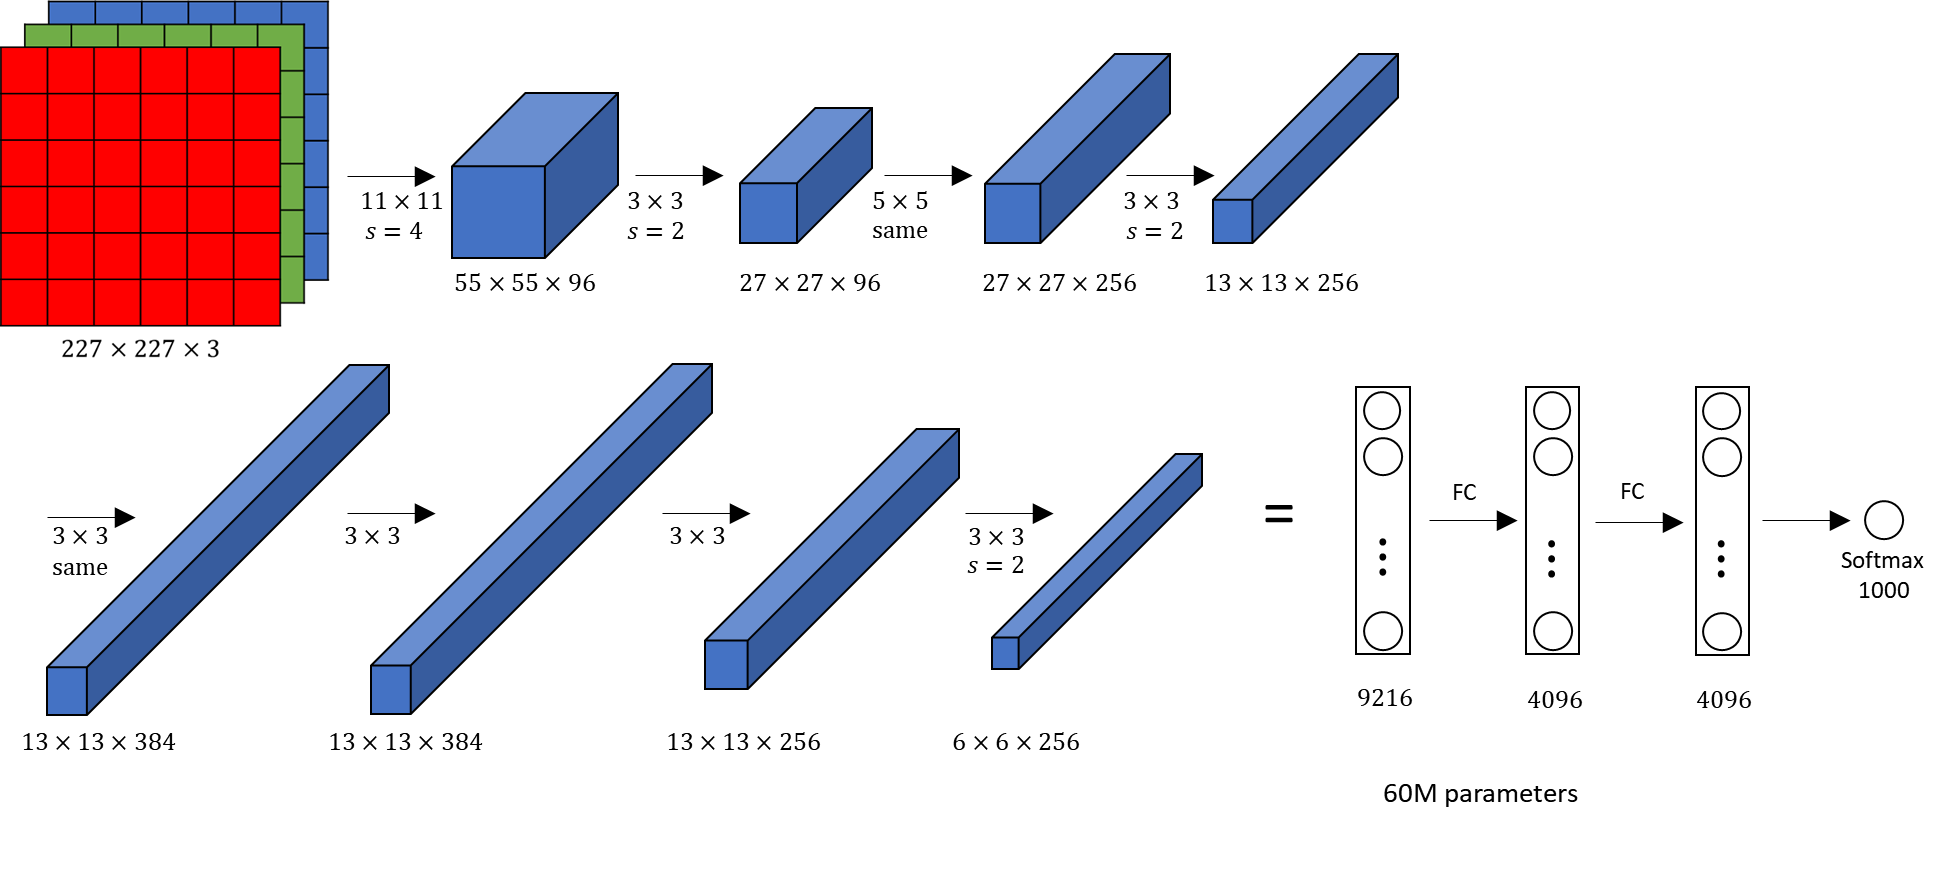





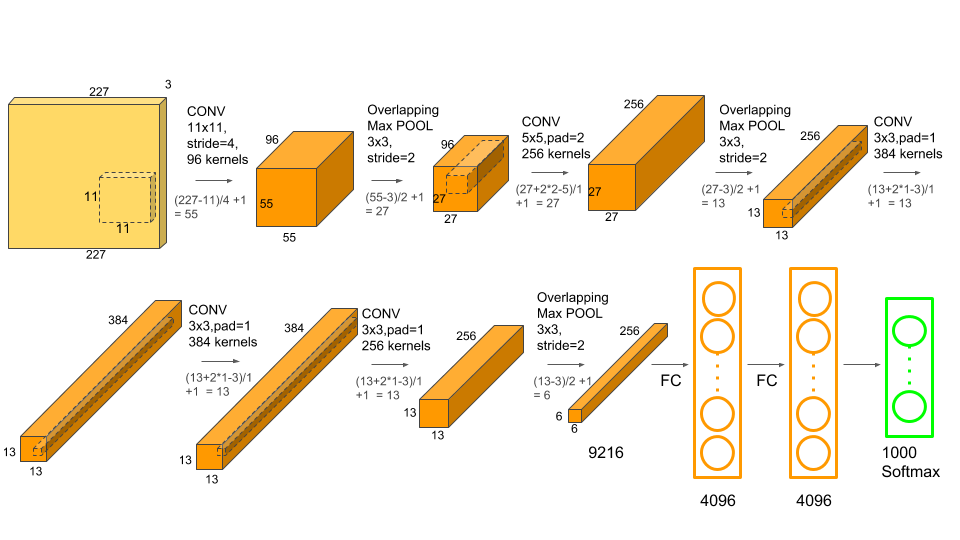




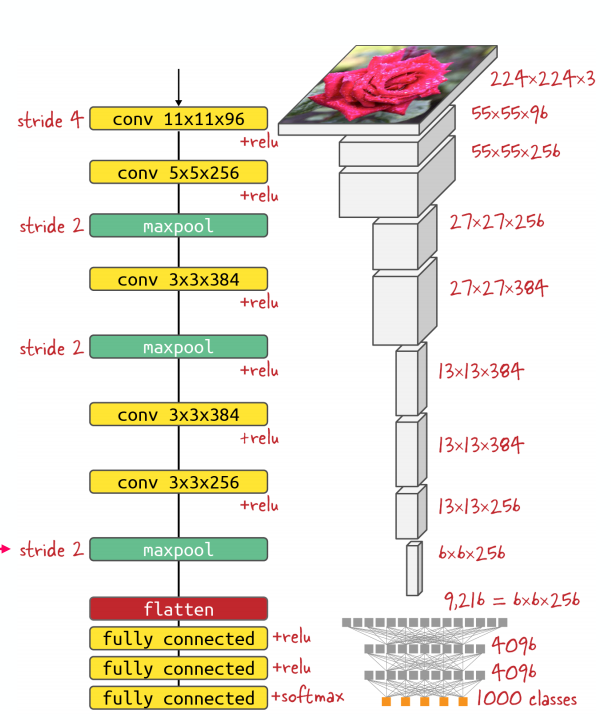

## Libraries

In [ ]:
import numpy as np

import torch
from torch import nn

import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data

In [ ]:
def get_train_valid_loader(data_dir, batch_size, augment, random_seed, valid_size= 0.1, shuffle= True):
  normalize = transforms.Normalize(
      mean=[0.4914, 0.4822, 0.4465],
      std=[0.2023, 0.1994, 0.2010],
    )

  valid_transform = transforms.Compose([
      transforms.Resize((227, 227)),
      transforms.ToTensor(),
      normalize
  ])

  if augment:
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding= 4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

  else:
    train_transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        normalize
    ])

  train_dataset = datasets.CIFAR10(root = data_dir,
                                   train= True,
                                   transform= train_transform,
                                   download= True
  )

  valid_dataset = datasets.CIFAR10(root = data_dir,
                                   train= True,
                                   transform= valid_transform,
                                   download= True
  )

  num_train = len(train_dataset)
  indices = list(range(num_train))
  split = int(np.floor(valid_size * num_train))

  if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

  train_idx, valid_idx = indices[split:], indices[:split]
  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size, sampler= train_sampler)
  valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size= batch_size, sampler= valid_sampler)

  return (train_loader, valid_loader)

def get_test_loader(data_dir, batch_size, shuffle = True):
  normalize = transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225],
  )

  test_transforms = transforms.Compose([
      transforms.Resize((227, 227)),
      transforms.ToTensor(),
      normalize
  ])

  test_dataset = datasets.CIFAR10(root= data_dir,
                                  train= False,
                                  transform= test_transforms,
                                  download = True)

  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= batch_size, shuffle= shuffle)

  return test_loader

In [ ]:
train_loader, valid_loader = get_train_valid_loader('./data', batch_size= 64, augment= False, random_seed= 1)
test_loader = get_test_loader('./data', batch_size= 64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## AlexNet Class

In [ ]:
class AlexNet(nn.Module):
  def __init__(self, num_classes= 10):
    super(AlexNet, self).__init__()
    self.layer1= nn.Sequential(
        nn.Conv2d(3, 96, kernel_size= 11, stride= 4),
        nn.ReLU(),
        nn.MaxPool2d(3, stride= 2)
    )
    self.layer2= nn.Sequential(
        nn.Conv2d(96, 256, kernel_size= 5, padding= 2),
        nn.ReLU(),
        nn.MaxPool2d(3, stride= 2),
    )
    self.layer3= nn.Sequential(
        nn.Conv2d(256, 384, kernel_size= 3, padding= 1),
        nn.ReLU(),
    )
    self.layer4= nn.Sequential(
        nn.Conv2d(384, 384, kernel_size= 3, padding= 1),
        nn.ReLU(),
    )
    self.layer5= nn.Sequential(
        nn.Conv2d(384,256, kernel_size= 3, padding= 1),
        nn.ReLU(),
        nn.MaxPool2d(3, stride= 2)
    )

    self.fc= nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(6 * 6* 256, 4096),
        nn.ReLU()
    )
    self.fc1 = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU()
    )
    self.fc2 = nn.Sequential(
        nn.Linear(4096, num_classes)
    )

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    out = out.reshape(out.size(0), -1)   # like flatten
    out = self.fc(out)
    out = self.fc1(out)
    out = self.fc2(out)

    return out

## HyperParameters

In [ ]:
batch_size = 64
learning_rate = 0.005
num_epochs = 20
num_classes = 10

model = AlexNet(num_classes).to(device)

cost = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay = 0.005, momentum = 0.9)

total_step= len(train_loader)

In [ ]:
# total parameters

pytorch_total_params = sum(p.numel() for p in model.parameters())

# only trainable parameters

pytorch_total_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(pytorch_total_params, pytorch_total_params_trainable)

58322314 58322314


## Train

In [ ]:
for epoch in range(num_epochs):
  for i, (img, label) in enumerate(train_loader):
    img= img.to(device)
    label= label.to(device)

    pred = model(img)
    loss = cost(pred, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

  with torch.no_grad():
    total = 0
    correct = 0

    for img, label in valid_loader:
      img = img.to(device)
      label = label.to(device)

      pred = model(img)

      _, predicted = torch.max(pred.data, 1)

      total += label.size(0)
      correct += (predicted == label).sum().item()

      del img, label, pred

    print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

## Test

In [ ]:
with torch.no_grad():
  total = 0
  correct = 0

  for img, label in test_loader:
    img = img.to(device)
    label = label.to(device)

    pred = model(img)

    _, predicted = torch.max(pred.data, 1)

    total += label.size(0)
    correct += (predicted == label).sum().item()

    del img, label, pred

  print('Accuracy of the network on the {} test images: {} %'.format(5000, 100 * correct / total))

Accuracy of the network on the 5000 validation images: 77.49 %
